<a href="https://colab.research.google.com/github/lkidane/Novoic-ML-challenge-/blob/master/Lidia_Kidane_Novoic_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Novoic ML challenge – text data

For this challenge I'll be using Keras with Tensorflow backend

### Prepare the data
Copy the dataset to a local directory – this should take a few seconds.

In [1]:
!mkdir -p data_nov  # Create directory
!gsutil -m cp -r gs://novoic-ml-challenge-text-data/* ./data_nov # Download data to directory

Copying gs://novoic-ml-challenge-text-data/LICENSE...
Copying gs://novoic-ml-challenge-text-data/README.md...
Copying gs://novoic-ml-challenge-text-data/data.txt...
- [3/3 files][468.7 KiB/468.7 KiB] 100% Done                                    
Operation completed over 3 objects/468.7 KiB.                                    


In [2]:
!ls data_nov # View downloaded elements

data.txt  LICENSE  README.md


In [3]:
!head -10 data_nov/data.txt #Read fist 10 lines of the file

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
ham	Ok lar... Joking wif u oni...
spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
ham	U dun say so early hor... U c already then say...
ham	Nah I don't think he goes to usf, he lives around here though
spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
ham	Even my brother is not like to speak with me. They treat me like aids patent.
ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
spam	H

In [0]:
# Read the data to notebook
with open('data_nov/data.txt', 'r') as f:
    msgs = f.read().splitlines()

In [5]:
msgs[0:9] #Read First 10 lines of the list

['ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
 'ham\tOk lar... Joking wif u oni...',
 "spam\tFree entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
 'ham\tU dun say so early hor... U c already then say...',
 "ham\tNah I don't think he goes to usf, he lives around here though",
 "spam\tFreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv",
 'ham\tEven my brother is not like to speak with me. They treat me like aids patent.',
 "ham\tAs per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune",
 'spam\tWINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Cl

In [6]:
# View 10th and 11th message
print(msgs[10])
print(msgs[11])

ham	I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.
spam	SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info


Now I see the data for what it is, I need to split each line into a message and a label.

Ordinarily I could have used pandas with sep = '\t' but I'll like to try some other hand crafted functions.

In [0]:
# Data Loading function
def load_data(path = 'data_nov/data.txt'):
    """
    INPUT:
    .txt dataset
    OUTPUT:
    messages: All the messages stripped of their labels
    labels: All message labels
    """
    messages, labels = [], []
    with open(path) as m:
        for line in m:
            split_lines = line.split()
            labels.append(split_lines[0].strip())
            messages.append(' '.join(split_lines[1:]).strip())
    return messages, labels

In [0]:
# Call our function and parse to two variables
messages, target = load_data()

In [9]:
# Check to verify both target and messages are of same length
len(target), len(messages)

(5574, 5574)

In [10]:
# Import data using pandas just to see how the data loads in pandas.
import pandas as pd
data = pd.read_table('data_nov/data.txt', sep='\t', header=None)
data.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### The Challenge

Tasks:

  1. Data exploration/visualization
  2. Binary classification
  3. Unsupervised clustering
  4. Model explainability

### 1. Data Exploration and Visualization

In [0]:
#import modules 
import numpy as np
import string
import re
import matplotlib.pyplot as plt

In [12]:
#Check to be sure I have only 2 unique clases of spam and ham in our targets
np.unique(target)

array(['ham', 'spam'], dtype='<U4')

In [13]:
# See number of unique cases for each class
_,number_of_unique_values = np.unique(target, return_counts=True)
print('Unique Values', number_of_unique_values)

Unique Values [4827  747]


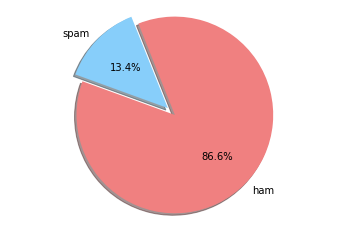

In [14]:
# See a plot of the size of both labels.
labels, sizes = np.unique(target, return_counts=True)
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=160)

plt.axis('equal')
plt.show()

Now I see the amount of imbalance in the labels. I'll attempt cleaning the messages (removing stopwords and punctuations) so I can have the cleaned out messages.

1. Remove puntuations.
2. Normalize the case in the sentences.
3. Split sentences into words.
4. Remove stopwords.
5. Remove numerics and join strings together.
5. Plot Wordcloud.

In [15]:
messages[10]

"I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."

In [16]:
# First I remove punctuations from the messages.
punctuations = str.maketrans('', '', string.punctuation) # The string function allows us access to custom punctuations
stripped_messages = []
for word in messages:
  stripped_messages.append(word.translate(punctuations))
stripped_messages[10]

'Im gonna be home soon and i dont want to talk about this stuff anymore tonight k Ive cried enough today'

In [17]:
# Secondly, I change to lower case
lower_messages = []
for sentence in stripped_messages:
  lower_messages.append(sentence.lower())
lower_messages[10]

'im gonna be home soon and i dont want to talk about this stuff anymore tonight k ive cried enough today'

In [18]:
#Tekonization
# Breaking down the sentences into words for each in the messages list
messages1 = []
for i in lower_messages:
  messages1.append(i.split())
messages1[10]

['im',
 'gonna',
 'be',
 'home',
 'soon',
 'and',
 'i',
 'dont',
 'want',
 'to',
 'talk',
 'about',
 'this',
 'stuff',
 'anymore',
 'tonight',
 'k',
 'ive',
 'cried',
 'enough',
 'today']

In [19]:
# I'll now remove stopwords from the text.
#To do this I need to download the NLTK stopwords dictionary
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
# Import stopwords from NLTK module and print them out
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [21]:
# I'll now set my stopwords to a list and iterate through the list. 
stop_words = list(set(stopwords.words('english')))
full = []
for sentence in messages1:
  temp = []
  for word in sentence:
    if word not in stop_words:
      temp.append(word)
  full.append(temp)
full[10]

['im',
 'gonna',
 'home',
 'soon',
 'dont',
 'want',
 'talk',
 'stuff',
 'anymore',
 'tonight',
 'k',
 'ive',
 'cried',
 'enough',
 'today']

In [22]:
# Verify that the full list is same size as our initial data so 
len(full)

5574

In [23]:
# Now I finally remove numerics from the data and join our text together
full1 = []
# Iterate through the string, removing non-alphabets
for sentence in full:
  no_digits = []
  for i in sentence:
    if i.isalpha():
      no_digits.append(i)
  # Now join all elements of the list with ' ' which puts all of the characters together.
  result = ' '.join(no_digits)
  full1.append(result)
full1[10]

'im gonna home soon dont want talk stuff anymore tonight k ive cried enough today'

In [24]:
# Verify the length of the data
len(full1)

5574

In [0]:
# Lets plot a word cloud of the whole dataset
from wordcloud import WordCloud
import matplotlib.pyplot as plt

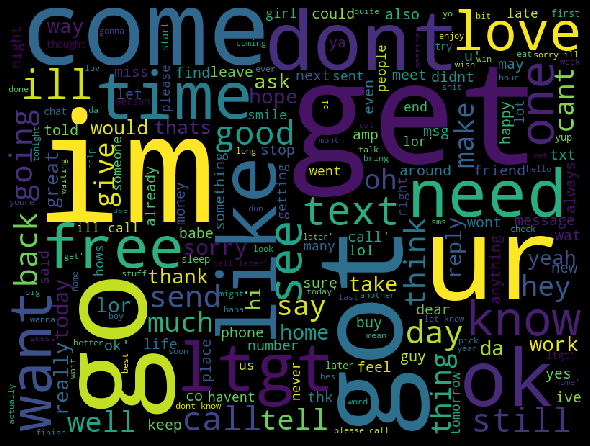

In [52]:
# Set our image width and height
wordcloud = WordCloud(width = 800, height = 600, 
                      #background_color ='white', 
                      stopwords = stop_words, 
                      min_font_size = 10).generate(str(full1))
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = 'k') 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig('wordcloud_data.png')
plt.show() 

Create 2 New wordcloud plots
  1. ham only messages 
  2. spam only messages

In [0]:
# Import modules
from sklearn.feature_extraction.text import CountVectorizer
import plotly.graph_objs as go
import pandas as pd

In [0]:
# I'll use the count vectorizer module to get the count of words in my corpus
def get_top_n_words(corpus, n=None):
  vec = CountVectorizer(stop_words = 'english').fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]

In [0]:
# Get the top 20 words
common_words = get_top_n_words(full1, 20)

In [28]:
# print the words and frequency
for word, freq in common_words:
    print(word, freq)

im 464
ur 390
dont 287
ok 278
ltgt 276
free 275
know 257
like 244
got 239
ill 239
good 236
come 229
time 208
day 203
love 200
want 193
send 191
text 188
going 171
need 167


In [30]:
# Send the series object to a dataframe
df2 = pd.DataFrame(common_words, columns = ['top_words' , 'count'])
df2.head()

,top_words,count
0,im,464
1,ur,390
2,dont,287
3,ok,278
4,ltgt,276


In [31]:
# Create a plot of the data
fig = go.Figure( go.Bar(x =df2['top_words'], y = df2['count']))
fig.show()

In [32]:
# Check the dataframe 
len(target), len(full1)

(5574, 5574)

### 2. Binary classification

Now I have our dataset, I will tokenize (vectorize) the cleaned dataset, pad the sequence of words and build a binary classifier for the task.

In [33]:
# Import modules for model
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
# Import tokenizer
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [0]:
# First we will setup a sequence length, an embedding size and a test size
sequence_length = 200 # the length of all sequences (number of words per sample)
embedding_size = 100  # Using 100-Dimensional GloVe embedding vectors
test_size = 0.25 # ratio of testing set

# to convert labels to integers and vice-versa
label2int = {"ham": 0, "spam": 1}
int2label = {0: "ham", 1: "spam"}

In [35]:
type(full1), type(target)

(list, list)

In [0]:
# convert to numpy arrays
X = np.array(full1)
y = np.array(target)

In [37]:
# Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=7)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4180,), (1394,), (4180,), (1394,))

In [0]:
# Initialize the tokenizer
tokenizer = Tokenizer()

In [39]:
X_train[10]

'ok c ü'

In [40]:
# Text tokenization
# vectorizing text, turning each text into sequence of integers
tokenizer.fit_on_texts(X_train)
# convert to sequence of integers
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_train[10]

[8, 91, 23]

In [0]:
# pad sequences at the beginning of each sequence with 0's
# for example if SEQUENCE_LENGTH=4:
# [[5, 3, 2], [5, 1, 2, 3], [3, 4]]
# will be transformed to:
# [[0, 5, 3, 2], [5, 1, 2, 3], [0, 0, 3, 4]]
X_train = pad_sequences(X_train, maxlen=sequence_length)
X_test = pad_sequences(X_test, maxlen=sequence_length)

In [42]:
# Check the padding
X_train[10]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8, 91, 23], dtype=int32)

In [43]:
# Verify the data shape
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4180, 200), (4180,), (1394, 200), (1394,))

In [44]:
y_train[10]

'ham'

In [0]:
# One Hot encoding labels
# [spam, ham, spam, ham, ham] will be converted to:
# [1, 0, 1, 0, 1] and then to:
# [[0, 1], [1, 0], [0, 1], [1, 0], [0, 1]]
y_train = [label2int[label] for label in y_train]
y_test = [label2int[label] for label in y_test]

In [46]:
y_train[0]

0

Embeddings layer is a word representation layer that is learned jointly with a neural network model on a specific natural language processing task.
This approach of learning an embedding layer requires a lot of training data and can be slow, but will learn an embedding both targeted to the specific text data and the NLP task.

### Deep Learning Model

In [47]:
# Create the model
model = Sequential()
model.add(Embedding(embedding_size, 32, input_length=sequence_length))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 32)           3200      
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               1600250   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 251       
Total params: 1,603,701
Trainable params: 1,603,701
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Import modules to verify model
import keras.metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve,precision_recall_curve, auc

In [49]:
type(X_train), type(y_train)

(numpy.ndarray, list)

In [50]:
y_train, y_test = np.array(y_train), np.array(y_test)
type(y_train)

numpy.ndarray

In [51]:
# print our data shapes for consistency
print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)
print("y_train.shape:", y_train.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (4180, 200)
X_test.shape: (1394, 200)
y_train.shape: (4180,)
y_test.shape: (1394,)


In [52]:
# train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    batch_size=64, epochs=20,                 
                    verbose=1)




Train on 4180 samples, validate on 1394 samples
Epoch 1/20





4180/4180 [==============================] - 9s 2ms/step - loss: 0.3315 - acc: 0.8744 - val_loss: 0.2616 - val_acc: 0.8737
Epoch 2/20
4180/4180 [==============================] - 1s 139us/step - loss: 0.1484 - acc: 0.9512 - val_loss: 0.1407 - val_acc: 0.9584
Epoch 3/20
4180/4180 [==============================] - 1s 139us/step - loss: 0.1168 - acc: 0.9612 - val_loss: 0.1363 - val_acc: 0.9620
Epoch 4/20
4180/4180 [==============================] - 1s 140us/step - loss: 0.1008 - acc: 0.9696 - val_loss: 0.1100 - val_acc: 0.9713
Epoch 5/20
4180/4180 [==============================] - 1s 140us/step - loss: 0.0947 - acc: 0.9711 - val_loss: 0.1090 - val_acc: 0.9648
Epoch 6/20
4180/4180 [==============================] - 1s 137us/step - loss: 0.0881 - acc: 0.9720 - val_loss: 0.1061 - val_acc: 0.9735
Epoch 7/20
4180/4180 [==============================] - 1s 136us/step - loss: 0.0847 - acc: 0.9768 - val_loss: 0.1064 - val_acc: 0

In [53]:
# get the loss and metrics
result = model.evaluate(X_test, y_test)
# # extract those
loss = result[0]
accuracy = result[1]
# print accuracy
print(f"[+] Accuracy: {accuracy*100:.2f}%")

1394/1394 [==============================] - 0s 72us/step
[+] Accuracy: 96.34%


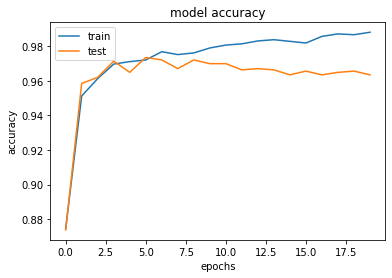

In [57]:
# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

From our results on the train and test results for a simple neural network architecture, we see an accuracy of 98.59% accuracy on the train and 96.27%. This is suspiciously good and needs to be investigated. I know the data is imbalanced, and since I did not deal with the imbalance yet, I probably need to test other model metrics like recall and precision before concluding or persisting any one model.

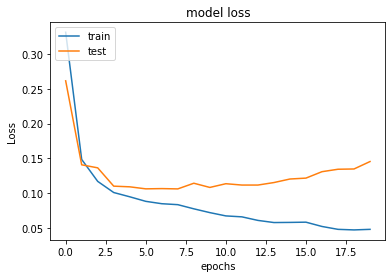

In [58]:
# Summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [0]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test, verbose=0)

In [60]:
yhat_probs.shape

(1394, 1)

In [0]:
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

In [65]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.963415
Precision: 0.939394
Recall: 0.790816
F1 score: 0.858726


No Skill: ROC AUC=0.500
Neural Model: ROC AUC=0.966


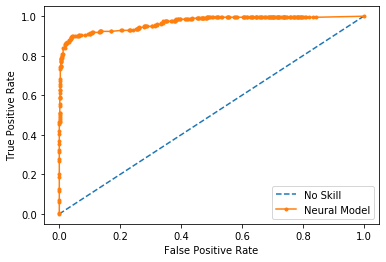

In [71]:
# predict probabilities
yhat_probs = model.predict(X_test, verbose=0)
# keep probabilities for the positive outcome only
yhat_probs = yhat_probs[:, 0]
# Generate a no skill prediction
ns_probs = [0 for _ in range(len(y_test))]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
nn_auc = roc_auc_score(y_test, yhat_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Neural Model: ROC AUC=%.3f' % (nn_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
nn_fpr, nn_tpr, _ = roc_curve(y_test, yhat_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(nn_fpr, nn_tpr, marker='.', label='Neural Model')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Neural Model: f1=0.859 auc=0.916


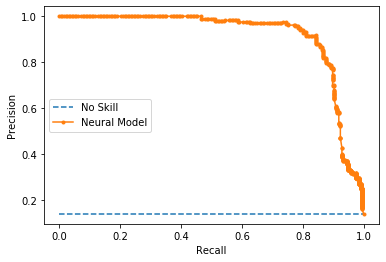

In [94]:
# keep probabilities for the positive outcome only
nn_precision, nn_recall, _ = precision_recall_curve(y_test, yhat_probs)
nn_f1, nn_auc = f1_score(y_test, yhat_classes), auc(nn_recall, nn_precision)
# summarize scores
print('Neural Model: f1=%.3f auc=%.3f' % (nn_f1, nn_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1] ,[no_skill,no_skill ],linestyle='--', label='No Skill')
plt.plot(nn_recall, nn_precision, marker='.', label='Neural Model')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

Our Neural Network Model seems to be performing really good on our data as seen from the precision/recall curve as well as the AUC curve. This is without persisting or building a deep model. 

Let's take a step back and build a simple machine learning model for the same task.

Let's try a simple machine learning model. **Naive Bayes**

### Naive Bayes Model

In [0]:
# Import modules
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, auc, confusion_matrix, plot_precision_recall_curve, roc_auc_score, roc_curve, precision_recall_curve

In [0]:
# Instantiate the class
gnb = GaussianNB()

In [81]:
# Fit a naive bayes model
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 1394 points : 1175


In [82]:
# Print classification report
print(classification_report(y_test, y_pred, labels=[0,1], target_names=['ham', 'spam']))

              precision    recall  f1-score   support

         ham       1.00      0.02      0.04      1198
        spam       0.14      1.00      0.25       196

    accuracy                           0.16      1394
   macro avg       0.57      0.51      0.14      1394
weighted avg       0.88      0.16      0.07      1394



As expected, our naive bayes model is performing badly on the spam class. I need to do some upsampling on the spam class to get a much better distribution for modelling. Why upsampling? Because of the heavy skew in the data as noticed above, downsampling the higher class will result in a really small dataset for building a model and may still arrive at terrible results.

In [83]:
# check confusion matrix
print(confusion_matrix(y_test, y_pred, labels=[0, 1]))

[[  23 1175]
 [   0  196]]


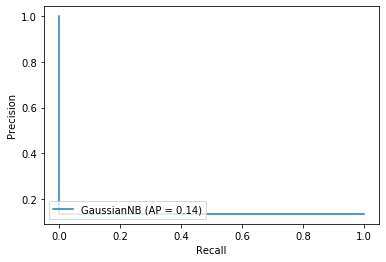

In [84]:
# plot a precision recall curve
plot_precision_recall_curve(gnb, X_train, y_train)

This now begs the question, why is the naive bayes model performing poorly on this data?

Those follwing techniques might improve the performance:
  1. Upsampling lower class.
  2. Downsampling higher class
  3. Changing the data embeddings, vectorization and sequence 
padding.
  4. Try bag of words method.

 I'll take an unsupervised machine learning look at the data.

### Unsupervised Segmentation.

In [0]:
# Import KMeans algorithm.
from sklearn.cluster import KMeans

In [0]:
# Test a number of k values to select optimal k value to use
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_train)
    distortions.append(kmeanModel.inertia_)

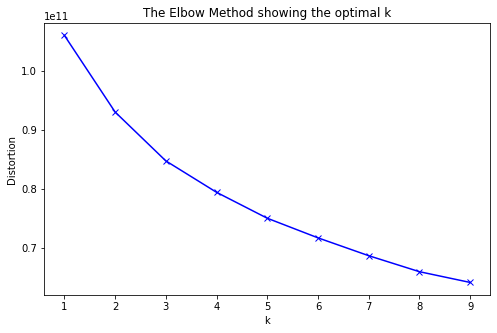

In [87]:
# Plot the optimal k
plt.figure(figsize=(8,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

After using KMeans clustering algorithm and running against a number of K values (within the range 1 - 10), we can see the elbow method plot above.
If I am to select an optimal K from the above, I'll select 2. However, this still is quite vague begging the issue of the data. 

Thus I can further this by taking a look at other distances for finding segments in data (Minowski, manhattan, euclidean, etc) and see if these clearly distinct the data points.